In [1]:
# Importing PyTorch, torchvision, and other libraries needed for the task
import torch  # PyTorch for building and training neural networks
from torchvision.datasets import ImageFolder  # To load images from a folder structure
from torchvision import transforms  # For applying transformations (e.g., resizing, normalizing) to the images
from torch.utils.data import dataloader, DataLoader  # To create data loaders for training and testing
import matplotlib.pyplot as plt  # For plotting graphs (like loss/accuracy over time)
from torch import optim  # PyTorch's optimization module for updating weights
from torch import nn  # PyTorch's neural network module, used to define layers
# Importing specific metrics from torchmetrics
from torchmetrics import Recall, Precision, Accuracy, AUROC  # Metrics to evaluate model performance

In [2]:
# Defining transformations to apply to the training images
train_transform = transforms.Compose([  # Compose allows stacking multiple transformations together
    transforms.ToTensor(),  # Converts images to PyTorch tensors (from 0-255 range to 0-1 float range)
    transforms.Resize((64, 64)),  # Resizes the images to 64x64 pixels
])
# Defining transformations to apply to the test images
test_transform = transforms.Compose([  # Similar transformations for test images to ensure consistency
    transforms.ToTensor(),  # Converts images to PyTorch tensors
    transforms.Resize((64, 64))  # Resizes test images to 64x64 pixels
])


In [3]:
# Loading the training dataset from the specified folder
dataset_train = ImageFolder(
    'data/Combined dataset/train',  # Path to the training dataset
    transform=train_transform  # Applying the defined transformations (ToTensor and Resize) to the training data
)
# Loading the testing dataset from the specified folder
dataset_test = ImageFolder(
    'data/Combined dataset/test',  # Path to the test dataset
    transform=test_transform  # Applying the defined transformations to the test data
)


In [4]:
# Creating a DataLoader for the training dataset
dataloader_train = DataLoader(dataset_train,  # The training dataset loaded using ImageFolder
                              batch_size=32,  # Number of images to be passed through the network at once
                              shuffle=True  # Randomly shuffle the data at each epoch for better training
)

# Creating a DataLoader for the test dataset
dataloader_test = DataLoader(dataset_test,  # The test dataset loaded using ImageFolder
                             batch_size=32,  # The same batch size as training to ensure consistency
                             shuffle=True  # Optionally shuffle test data (can be False, but True here for demonstration)
)


In [5]:
# Fetching one batch of data from the training DataLoader
images, labels = next(iter(dataloader_train))  # 'iter' turns the DataLoader into an iterator, and 'next' gives the next batch
print(images.shape)  # Printing the shape of the image batch (e.g., [32, 3, 64, 64]), where:
# 32 = batch size, 3 = number of color channels (RGB), 64x64 = image dimensions

torch.Size([32, 3, 64, 64])


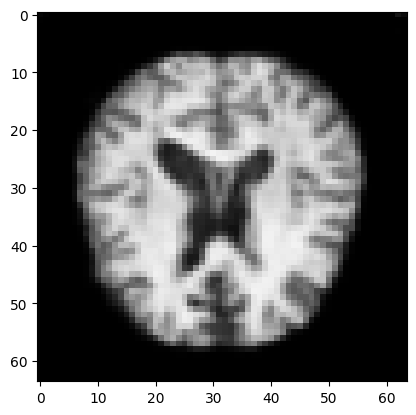

In [6]:
# Selecting the first image from the batch of images
image = images[0]  # Accessing the first image tensor in the batch

# Squeezing the tensor to remove any singleton dimensions (e.g., if the tensor shape is [1, 3, 64, 64])
image = image.squeeze().permute(1, 2, 0)  # Permuting the dimensions to [height, width, channels] for display

# Displaying the image using matplotlib
plt.imshow(image)  # Displaying the image; Matplotlib expects channels last format (H, W, C)
plt.show()  # Rendering the plot


In [7]:
# Defining a neural network architecture by subclassing nn.Module
class Net(nn.Module): 
    def __init__(self, num_classes):  # Constructor method that initializes the network
        super().__init__()  # Calling the parent class (nn.Module) constructor
        # Defining the feature extractor part of the network
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=2, padding=1),  # Convolutional layer: 3 input channels (RGB), 32 output channels
            nn.ELU(),  # Activation function to introduce non-linearity
            nn.MaxPool2d(kernel_size=2),  # Max pooling layer to reduce spatial dimensions
            nn.Conv2d(32, 64, kernel_size=2, padding=1),  # Second convolutional layer: 32 input channels, 64 output channels
            nn.ELU(),  # Another activation function
            nn.MaxPool2d(kernel_size=2),  # Second max pooling layer
            nn.Flatten()  # Flattening the output to feed into the fully connected layer
        )
        # Defining the classifier part of the network: a fully connected layer
        self.classifier = nn.Linear(64 * 16 * 16, num_classes)  # Takes flattened features and outputs class scores

    def forward(self, x):  # Forward pass through the network
        x = self.feature_extractor(x)  # Passing input through the feature extractor
        x = self.classifier(x)  # Passing extracted features to the classifier
        return x  # Returning the output (class scores)


In [8]:
# Initializing the neural network with the specified number of output classes
net = Net(num_classes=4)  # Creating an instance of the Net class with 4 output classes (e.g., for a 4-class classification problem)

# Defining the loss function for training
criterion = nn.CrossEntropyLoss()  # Cross entropy loss is commonly used for multi-class classification problems

# Initializing the optimizer for updating network weights
optimizer = optim.Adam(net.parameters(), lr=0.001)  # Using the Adam optimizer with a learning rate of 0.001


In [9]:
# Initializing metrics for model evaluation

# Metric for recall: Measures the ability of the model to find all relevant instances (true positives)
metric_recall = Recall(task='multiclass', num_classes=4, average='macro')  # 'macro' averages recall across all classes equally

# Metric for precision: Measures the ability of the model to identify only relevant instances (true positives among all predicted positives)
metric_precision = Precision(task='multiclass', num_classes=4, average='macro')  # 'macro' averages precision across all classes equally

# Metric for accuracy: Measures the overall correctness of the model's predictions
metric_accuracy = Accuracy(task='multiclass', num_classes=4, average='macro')  # 'macro' averages accuracy across all classes equally

# Metric for recall with no averaging: Provides recall for each class individually
metric_recall_m = Recall(task='multiclass', num_classes=4, average=None)  # 'None' returns recall for each class separately


In [10]:
# Training and evaluation loop for the model
for epoch in range(10):  # Looping through the specified number of epochs
    net.train()  # Set the model to training mode
    # Iterating through the training dataset
    for images, labels in dataloader_train:
        optimizer.zero_grad()  # Resetting the gradients for the optimizer
        output = net(images)  # Forward pass: getting model predictions for the current batch
        loss = criterion(output, labels)  # Calculating the loss using the predicted and actual labels
        loss.backward()  # Backward pass: computing gradients
        optimizer.step()  # Updating the model parameters

    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for evaluation
        # Iterating through the test dataset
        for images, labels in dataloader_test:
            output = net(images)  # Forward pass: getting predictions for the test batch
            _, pred = torch.max(output, 1)  # Getting the predicted class labels (index of max logit)
            # Updating metrics with the predictions and actual labels
            metric_accuracy(pred, labels)  # Computing accuracy
            metric_recall(pred, labels)  # Computing recall
            metric_precision(pred, labels)  # Computing precision
            metric_recall_m(pred, labels)  # Computing recall for each class separately

    # Computing final metrics after evaluating the test dataset
    precision = metric_precision.compute()  # Get the computed precision
    recall = metric_recall.compute()  # Get the computed recall
    accuracy = metric_accuracy.compute()  # Get the computed accuracy
    recall_m = metric_recall_m.compute()  # Get the computed recall for each class


In [11]:
# Printing the evaluation metrics after completing the training and testing loop
print(f'Precision: {precision}')  # Displaying the overall precision of the model
print(f'Recall: {recall}')  # Displaying the overall recall of the model
print(f'Accuracy: {accuracy}')  # Displaying the overall accuracy of the model
print(f'Recall per class: {recall_m}')  # Displaying the recall for each class individually


Precision: 0.8822296857833862
Recall: 0.8884312510490417
Accuracy: 0.8884312510490417
Recall per class: tensor([0.8575, 1.0000, 0.8605, 0.8357])


In [12]:
# Accessing the class-to-index mapping for the test dataset
class_to_idx = dataset_test.class_to_idx  # This returns a dictionary mapping class names to their corresponding indices
print(class_to_idx)  # Print the mapping to see which class corresponds to which index


{'Mild Impairment': 0, 'Moderate Impairment': 1, 'No Impairment': 2, 'Very Mild Impairment': 3}


In [13]:
# Creating a dictionary mapping class names to their corresponding recall values
recall_per_class = {
    k: recall_m[v].item()  # For each class name (k), get the recall value for the corresponding index (v)
    for k, v in dataset_test.class_to_idx.items()  # Iterating over the class-to-index mapping from the test dataset
}

print(recall_per_class)  # Print the recall values for each class

{'Mild Impairment': 0.8575419187545776, 'Moderate Impairment': 1.0, 'No Impairment': 0.8604687452316284, 'Very Mild Impairment': 0.8357142806053162}
